In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.utils import class_weight
import numpy as np
import tensorflow as tf
from tensorflow.keras import backend as K

In [ ]:
def CNN3(input_shape=(50, 50, 1)):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), padding='same', activation='relu', kernel_initializer='he_uniform', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(64, (3, 3), padding='same', activation='relu', kernel_initializer='he_uniform'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(128, (3, 3), padding='same', activation='relu', kernel_initializer='he_uniform'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.001)))
    model.add(Dropout(0.5))

    model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.001)))
    model.add(Dropout(0.5))

    model.add(Dense(1, activation='sigmoid'))
    return model

# Define the model
third_cnn = CNN3()

# Optimizer
optimizer = Adam(learning_rate=1e-5)

def focal_loss(gamma=2., alpha=0.25):
    def focal_loss_fixed(y_true, y_pred):
        epsilon = tf.keras.backend.epsilon()
        y_pred = tf.clip_by_value(y_pred, epsilon, 1. - epsilon)
        y_true = tf.cast(y_true, tf.float32)
        alpha_t = y_true * alpha + (tf.ones_like(y_true) - y_true) * (1 - alpha)
        p_t = y_true * y_pred + (tf.ones_like(y_true) - y_true) * (tf.ones_like(y_pred) - y_pred)
        fl = - alpha_t * tf.keras.backend.pow((tf.ones_like(y_true) - p_t), gamma) * tf.keras.backend.log(p_t)
        return tf.reduce_mean(fl)
    return focal_loss_fixed

third_cnn.compile(optimizer=optimizer, loss=focal_loss(), metrics=['accuracy'])


In [ ]:
import numpy as np
import h5py
import keras
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPooling2D, Dropout, Flatten, Dense
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from sklearn.utils import class_weight

In [ ]:
import numpy as np
import h5py

# Load datasets
with h5py.File('/content/drive/MyDrive/Dataset/traindataset.h5', 'r') as hdf5_file:
    X_train_images_np = np.array(hdf5_file['X'][:])
    y_train_labels_np = np.array(hdf5_file['Y'][:])

with h5py.File('/content/drive/MyDrive/Dataset/val.h5', 'r') as hdf5_file:
    X_val_images_np = np.array(hdf5_file['X'][:])
    y_val_labels_np = np.array(hdf5_file['Y'][:])

with h5py.File('/content/drive/MyDrive/Dataset/testdataset.h5', 'r') as hdf5_file:
    X_test_images_np = np.array(hdf5_file['X'][:])
    y_test_labels_np = np.array(hdf5_file['Y'][:])

# Ensure correct data shape
# Remove any extra dimensions (like (1297, 50, 50, 1, 1)) and make sure the shape is (batch_size, 50, 50, 1)
X_train_images_np = np.squeeze(X_train_images_np)  # Removes any dimensions of size 1
X_val_images_np = np.squeeze(X_val_images_np)
X_test_images_np = np.squeeze(X_test_images_np)

# Now, ensure the shape is (batch_size, 50, 50, 1)
if X_train_images_np.ndim == 3:  # if shape is (batch_size, 50, 50)
    X_train_images_np = np.expand_dims(X_train_images_np, axis=-1)  # Add channel dimension
if X_val_images_np.ndim == 3:
    X_val_images_np = np.expand_dims(X_val_images_np, axis=-1)
if X_test_images_np.ndim == 3:
    X_test_images_np = np.expand_dims(X_test_images_np, axis=-1)

# Convert one-hot encoded labels to binary if necessary
y_train_labels_np = np.argmax(y_train_labels_np, axis=1).reshape(-1, 1)
y_val_labels_np = np.argmax(y_val_labels_np, axis=1).reshape(-1, 1)
y_test_labels_np = np.argmax(y_test_labels_np, axis=1).reshape(-1, 1)





In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.utils import class_weight

# Eager execution for debugging
tf.config.run_functions_eagerly(True)

# Fix steps_per_epoch
steps_per_epoch = X_train_images_np.shape[0] // 32  # Replace 32 with the actual batch size
validation_steps = X_val_images_np.shape[0] // 32

# Define a simple single input generator (fixes potential issues with multi-input structure)
def single_input_generator(generator):
    for X_batch, y_batch in generator:
        yield X_batch, y_batch

# Use ImageDataGenerator for data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    fill_mode='nearest'
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

# Generate batches of augmented data
train_generator = train_datagen.flow(X_train_images_np, y_train_labels_np, batch_size=32, shuffle=True)
val_generator = val_test_datagen.flow(X_val_images_np, y_val_labels_np, batch_size=32, shuffle=False)
test_generator = val_test_datagen.flow(X_test_images_np, y_test_labels_np, batch_size=32, shuffle=False)
# Convert to tf.data.Dataset
train_multi_generator = tf.data.Dataset.from_generator(
    lambda: single_input_generator(train_generator),
    output_signature=(
        tf.TensorSpec(shape=(None, 50, 50, 1), dtype=tf.float32),
        tf.TensorSpec(shape=(None, 1), dtype=tf.float32) # Change the output signature to (None, 1)
    )
)

val_multi_generator = tf.data.Dataset.from_generator(
    lambda: single_input_generator(val_generator),
    output_signature=(
        tf.TensorSpec(shape=(None, 50, 50, 1), dtype=tf.float32),
        tf.TensorSpec(shape=(None, 1), dtype=tf.float32) # Change the output signature to (None, 1)
    )
)
test_multi_generator =tf.data.Dataset.from_generator(
    lambda: single_input_generator(test_generator),
    output_signature=(
        tf.TensorSpec(shape=(None, 50, 50, 1), dtype=tf.float32),
        tf.TensorSpec(shape=(None, 1), dtype=tf.float32),
        tf.TensorSpec(shape=(None, 1), dtype=tf.float32)
    )
)

/usr/local/lib/python3.11/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


In [ ]:
# Calculate class weights
class_weights = class_weight.compute_class_weight(
    'balanced',
    classes=np.unique(y_train_labels_np.flatten()),
    y=y_train_labels_np.flatten()
)

# Convert class weights to dictionary
class_weight_dict = {i: weight for i, weight in enumerate(class_weights)}
print("Class Weights:", class_weight_dict)


Class Weights: {0: 0.5973053892215568, 1: 3.0692307692307694}


In [ ]:
# Callbacks
early_stopping_3 = EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)
model_checkpoint_3 = ModelCheckpoint('best_model_3.keras', monitor='val_accuracy', save_best_only=True, verbose=1)
reduce_lr_3 = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1, min_lr=1e-7)


In [ ]:
# prompt: my model is giving less accuracy give me the code to increase the accuracy and get accuracte trainng predicstions

# Increase the number of epochs
epochs = 500 # You can experiment with different values, e.g., 100, 150

# Increase the batch size
batch_size = 64  # You can try 32, 128, or other values

# Fine-tune the learning rate
#optimizer = Adam(learning_rate=1e-5)

# Recompile the model with the new optimizer and learning rate
third_cnn.compile(optimizer=optimizer, loss=focal_loss(), metrics=['accuracy'])

# Train the model
history = third_cnn.fit(
    train_multi_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=500,
    validation_data=val_multi_generator,
    validation_steps=validation_steps,
    class_weight=class_weight_dict,
    callbacks=[early_stopping_3, model_checkpoint_3, reduce_lr_3],
    verbose=1
)


Epoch 1/500


/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


162/162 [==============================] - ETA: 0s - loss: 0.1212 - accuracy: 0.8369
Epoch 1: val_accuracy did not improve from 0.83359
162/162 [==============================] - 20s 123ms/step - loss: 0.1212 - accuracy: 0.8369 - val_loss: 0.1164 - val_accuracy: 0.8281 - lr: 1.0000e-05
Epoch 2/500
162/162 [==============================] - ETA: 0s - loss: 0.1207 - accuracy: 0.8370
Epoch 2: val_accuracy did not improve from 0.83359
162/162 [==============================] - 19s 116ms/step - loss: 0.1207 - accuracy: 0.8370 - val_loss: 0.1151 - val_accuracy: 0.8281 - lr: 1.0000e-05
Epoch 3/500
162/162 [==============================] - ETA: 0s - loss: 0.1203 - accuracy: 0.8369
Epoch 3: val_accuracy did not improve from 0.83359
162/162 [==============================] - 19s 117ms/step - loss: 0.1203 - accuracy: 0.8369 - val_loss: 0.1144 - val_accuracy: 0.8281 - lr: 1.0000e-05
Epoch 4/500
162/162 [==============================] - ETA: 0s - loss: 0.1201 - accuracy: 0.8372
Epoch 4: val_accur

In [ ]:
# prompt: acuracy of the third_cnn

# Evaluate the model on the test set
loss, accuracy = third_cnn.evaluate(test_generator, verbose=1)

print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

51/51 [==============================] - 1s 28ms/step - loss: 0.0436 - accuracy: 0.9223
Test Loss: 0.0436
Test Accuracy: 0.9223


In [ ]:
# prompt: save the model that should be loaed easily whenever used from drive

# Save the model to a file in your Google Drive
third_cnn.save('/content/drive/MyDrive/Dataset/improved_model_3_updated.h5')


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
# prompt: bu=ild the confusion matrix and classification report for the above model---best model_3 saves in keras print the test accuracy also

from sklearn.metrics import confusion_matrix, classification_report
import keras
from tensorflow.keras.optimizers import Adam #Import the Adam optimizer

# Load the best model
best_model = keras.models.load_model('best_model_3.keras', compile=False)

# Compile the model
# Add this line to compile the model with an optimizer and loss function
best_model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy']) # Example using Adam optimizer and binary crossentropy loss

# Predict on the test set
y_pred_prob = best_model.predict(test_generator)
y_pred = (y_pred_prob > 0.5).astype(int)

# Calculate confusion matrix
cm = confusion_matrix(y_test_labels_np, y_pred)
print("Confusion Matrix:\n", cm)

# Calculate classification report
cr = classification_report(y_test_labels_np, y_pred)
print("Classification Report:\n", cr)

# Evaluate the model on the test set
loss, accuracy = best_model.evaluate(test_generator)
print('Test accuracy:', accuracy)

51/51 [==============================] - 1s 20ms/step
Confusion Matrix:
 [[1323   17]
 [ 109  173]]
Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.99      0.95      1340
           1       0.91      0.61      0.73       282

    accuracy                           0.92      1622
   macro avg       0.92      0.80      0.84      1622
weighted avg       0.92      0.92      0.92      1622

 3/51 [>.............................] - ETA: 1s - loss: 0.3084 - accuracy: 0.9271

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


51/51 [==============================] - 1s 26ms/step - loss: 0.3298 - accuracy: 0.9223
Test accuracy: 0.9223181009292603


In [ ]:
=

from sklearn.metrics import confusion_matrix, classification_report

# Predict on the test set
y_pred_prob = third_cnn.predict(test_generator)
y_pred = (y_pred_prob > 0.5).astype(int)

# Calculate the confusion matrix
cm = confusion_matrix(y_test_labels_np, y_pred)
print("Confusion Matrix:\n", cm)

# Generate the classification report
cr = classification_report(y_test_labels_np, y_pred)
print("Classification Report:\n", cr)


51/51 [==============================] - 0s 8ms/step
Confusion Matrix:
 [[1192  148]
 [ 259   23]]
Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.89      0.85      1340
           1       0.13      0.08      0.10       282

    accuracy                           0.75      1622
   macro avg       0.48      0.49      0.48      1622
weighted avg       0.70      0.75      0.72      1622



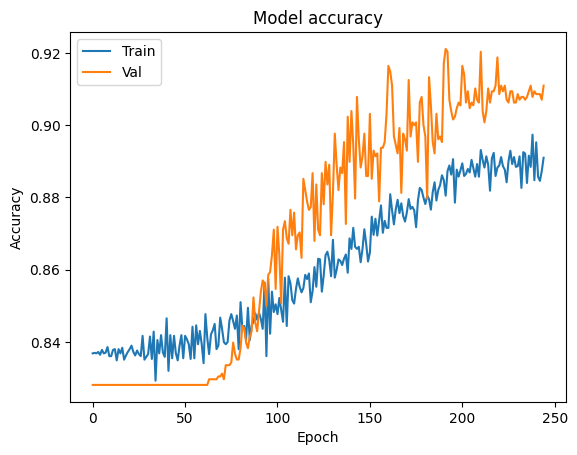

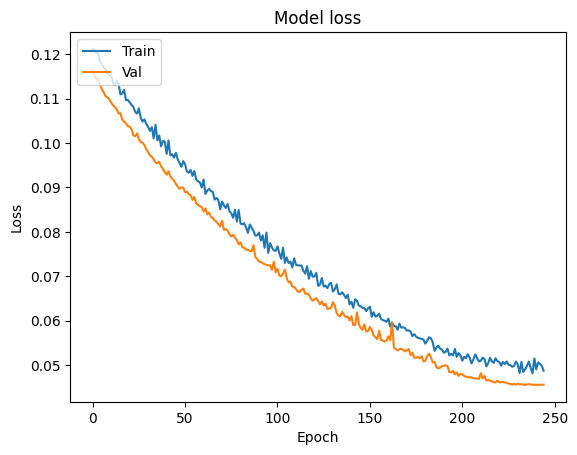

In [ ]:
# prompt: plot the accuracyis and loass corves seperately in two plots

import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()


In [ ]:
# Define the focal loss function
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import get_custom_objects
import tensorflow as tf  # Import tensorflow

def focal_loss_fixed(y_true, y_pred):
    gamma = 2.0
    alpha = 0.25
    pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
    pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))
    return -tf.reduce_sum(alpha * tf.pow(1. - pt_1, gamma) * tf.math.log(pt_1 + 1e-8)) - tf.reduce_sum((1 - alpha) * tf.pow(pt_0, gamma) * tf.math.log(1. - pt_0 + 1e-8))

get_custom_objects().update({'focal_loss_fixed': focal_loss_fixed})


# Load the datasets from the HDF5 files
with h5py.File('/content/drive/MyDrive/Dataset/traindataset.h5', 'r') as hdf5_file:
    X_train_images_np = np.array(hdf5_file['X'][:])
    y_train_labels_np = np.array(hdf5_file['Y'][:])

with h5py.File('/content/drive/MyDrive/Dataset/val.h5', 'r') as hdf5_file:
    X_val_images_np = np.array(hdf5_file['X'][:])
    y_val_labels_np = np.array(hdf5_file['Y'][:])

with h5py.File('/content/drive/MyDrive/Dataset/testdataset.h5', 'r') as hdf5_file:
    X_test_images_np = np.array(hdf5_file['X'][:])
    y_test_labels_np = np.array(hdf5_file['Y'][:])

# Reshape the data if necessary
if X_train_images_np.ndim == 3:
    X_train_images_np = np.expand_dims(X_train_images_np, axis=-1)
if X_val_images_np.ndim == 3:
    X_val_images_np = np.expand_dims(X_val_images_np, axis=-1)
if X_test_images_np.ndim == 3:
    X_test_images_np = np.expand_dims(X_test_images_np, axis=-1)

print("Training set shape:", X_train_images_np.shape, y_train_labels_np.shape)
print("Validation set shape:", X_val_images_np.shape, y_val_labels_np.shape)
print("Test set shape:", X_test_images_np.shape, y_test_labels_np.shape)

# Create ImageDataGenerators for augmented training, validation, and test sets
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=20,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Create generators from the in-memory datasets
batch_size = 32
img_height, img_width = X_train_images_np.shape[1], X_train_images_np.shape[2]

train_generator = train_datagen.flow(X_train_images_np, y_train_labels_np, batch_size=batch_size)
val_generator = val_datagen.flow(X_val_images_np, y_val_labels_np, batch_size=batch_size)
test_generator = test_datagen.flow(X_test_images_np, y_test_labels_np, batch_size=batch_size, shuffle=False)

model_1 = load_model('/content/drive/MyDrive/Dataset/improved_model_1.h5', custom_objects={'focal_loss_fixed': focal_loss_fixed}, compile=False)  # Load without compiling
model_2 = load_model('/content/drive/MyDrive/Dataset/improved_model_2.h5', custom_objects={'focal_loss_fixed': focal_loss_fixed}, compile=False)  # Load without compiling
model_3= load_model('/content/drive/MyDrive/Dataset/improved_model_3_updated.h5', custom_objects={'focal_loss_fixed': focal_loss_fixed}, compile=False)  # Load without compiling
# Compile the models after loading
model_1.compile(optimizer='adam', loss=focal_loss_fixed, metrics=['accuracy'])
model_2.compile(optimizer='adam', loss=focal_loss_fixed, metrics=['accuracy'])
model_3.compile(optimizer='adam', loss=focal_loss_fixed, metrics=['accuracy'])


Training set shape: (5187, 50, 50, 1) (5187, 2)
Validation set shape: (1297, 50, 50, 1) (1297, 2)
Test set shape: (1622, 50, 50, 1) (1622, 2)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
y_pred_prob_1 = model_1.predict(test_generator)
y_pred_prob_2 = model_2.predict(test_generator)
y_pred_prob_3 = model_3.predict(test_generator)

# Soft Voting Mechanism
y_pred_prob_ensemble = (y_pred_prob_1 + y_pred_prob_2 + y_pred_prob_3) / 3
y_pred_ensemble = (y_pred_prob_ensemble > 0.5).astype(int)

if len(y_test_labels_np.shape) > 1 and y_test_labels_np.shape[1] > 1:  # one-hot encoded
    y_test_labels_np = np.argmax(y_test_labels_np, axis=1)
y_pred_ensemble = np.argmax(y_pred_ensemble, axis=1)
cm_ensemble = confusion_matrix(y_test_labels_np, y_pred_ensemble)
print("Ensemble Confusion Matrix:\n", cm_ensemble)
cr_ensemble = classification_report(y_test_labels_np, y_pred_ensemble)
print("Ensemble Classification Report:\n", cr_ensemble)
ensemble_accuracy = np.mean(y_pred_ensemble == y_test_labels_np)
print("Ensemble Accuracy:", ensemble_accuracy)


 1/51 ━━━━━━━━━━━━━━━━━━━━ 5s 108ms/step

/usr/local/lib/python3.11/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


51/51 ━━━━━━━━━━━━━━━━━━━━ 7s 146ms/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 31s 604ms/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step
Ensemble Confusion Matrix:
 [[1326   14]
 [  60  222]]
Ensemble Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.99      0.97      1340
           1       0.94      0.79      0.86       282

    accuracy                           0.95      1622
   macro avg       0.95      0.89      0.91      1622
weighted avg       0.95      0.95      0.95      1622

Ensemble Accuracy: 0.9543773119605425
